In [ ]:
pip install yfinance pandas numpy matplotlib scikit-learn tensorflow

In [72]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
import math

Pengambilan Data

In [73]:
# Tentukan ticker dan periode data
ticker = 'ETH-USD'
start_date = '2021-01-01'
end_date = '2025-07-01' # Anda bisa sesuaikan tanggal akhir

# Unduh data menggunakan yfinance
data = yf.download(ticker, start=start_date, end=end_date)

# Tampilkan 5 baris pertama
data.head()

/tmp/ipython-input-73-590478911.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
Date,,,,,
2021-01-01,730.367554,749.201843,719.792236,737.708374,13652004358
2021-01-02,774.534973,786.798462,718.109497,730.402649,19740771179
2021-01-03,975.507690,1006.565002,771.561646,774.511841,45200463368
2021-01-04,1040.233032,1153.189209,912.305359,977.058838,56945985763
2021-01-05,1100.006104,1129.371460,986.811279,1041.498779,41535932781


PREPROCESSING

In [74]:
data.shape

(1642, 5)

In [75]:
# Mengecek Missing Value dari eth
missing_value = data.isnull().sum()
print(missing_value)

Price   Ticker 
Close   ETH-USD    0
High    ETH-USD    0
Low     ETH-USD    0
Open    ETH-USD    0
Volume  ETH-USD    0
dtype: int64


In [76]:
# Mengecek Data Duplikat
duplicates = data.duplicated()

# Menampilkan Baris yang Duplikat
print("Baris yang Duplikat:")
print(data[duplicates])

# Menampilkan Jumlah Data Duplikat
print("\nJumlah Data Duplikat:")
print(duplicates.sum())

Baris yang Duplikat:
Empty DataFrame
Columns: [(Close, ETH-USD), (High, ETH-USD), (Low, ETH-USD), (Open, ETH-USD), (Volume, ETH-USD)]
Index: []

Jumlah Data Duplikat:
0


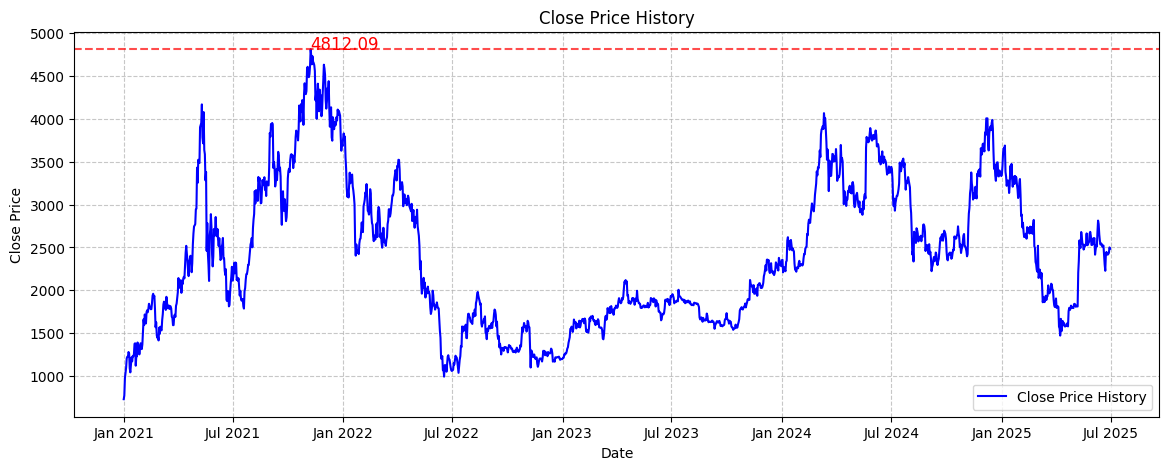

In [77]:
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Pastikan kolom Close adalah Series
close_series = data['Close'].squeeze()

sns.lineplot(x=data.index, y=close_series, label='Close Price History', color='blue')

max_price = close_series.max()
max_price_date = close_series.idxmax()

# Annotate the highest price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


Normalisasi Data

In [78]:
from joblib import dump
# Use only the closing price
dataset = data['Close'].values.reshape(-1, 1)

# Normalize data to a 0-1 scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

nama_file = 'scaler.pkl'
dump(scaler, nama_file)

['scaler.pkl']

In [79]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range (len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

Split Data

In [80]:
sequence_length = 30 # 30 hari kedepan

# disini kita melakukan split data untuk train dan test
train_size = int(len(scaled_data) * 0.8) # 80% untuk data training
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:] # sisanya 20% untuk data testing

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print(f"\n📊 Ukuran data Latihan (Train): {X_train.shape}")
print(f"📊 Ukuran data Uji (Test):    {X_test.shape}")


📊 Ukuran data Latihan (Train): (1283, 30, 1)
📊 Ukuran data Uji (Test):    (299, 30, 1)


Pembuatan Model

In [108]:
# Definisikan arsitektur model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=50, return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=1))

# Kompilasi model
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.summary()
history = model_gru.fit(X_train, y_train,validation_split=0.15, epochs=70, batch_size=32, validation_data=(X_test, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_30 (GRU)                    │ (None, 30, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_31 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0587 - val_loss: 0.0021
Epoch 2/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 3/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 4/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 5/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 6/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 7/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 8/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 9/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 10/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 11/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 12/70
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0

Save Model

In [ ]:
import os

# Simpan model
if not os.path.exists('models'):
    os.makedirs('models')
model_gru.save('models/GRU_ETH_MODEL.h5')
print("\nModel GRU berhasil dilatih dan disimpan di 'models'")


Model GRU berhasil dilatih dan disimpan di 'models'


Evaluasi Model

In [109]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Prediksi dan inverse transform
predictions = model_gru.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
# Evaluasi
mse_gru = mean_squared_error(y_test_scaled, predictions)
rmse_gru = np.sqrt(mse_gru)
mape_gru = mean_absolute_percentage_error(y_test_scaled, predictions)
r2_gru = r2_score(y_test_scaled, predictions)

# Tampilkan hasil evaluasi
print(f"📉 Root Mean Squared Error (RMSE): {rmse_gru:.2f} USD")
print(f"📈 R² Score: {r2_gru:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📉 Root Mean Squared Error (RMSE): 101.37 USD
📈 R² Score: 0.9718


In [110]:
last_30_days = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)
X_predict = []
X_predict.append(last_30_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
predicted_price = model_gru.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Ethereum Price: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Ethereum Price: 2481.568603515625


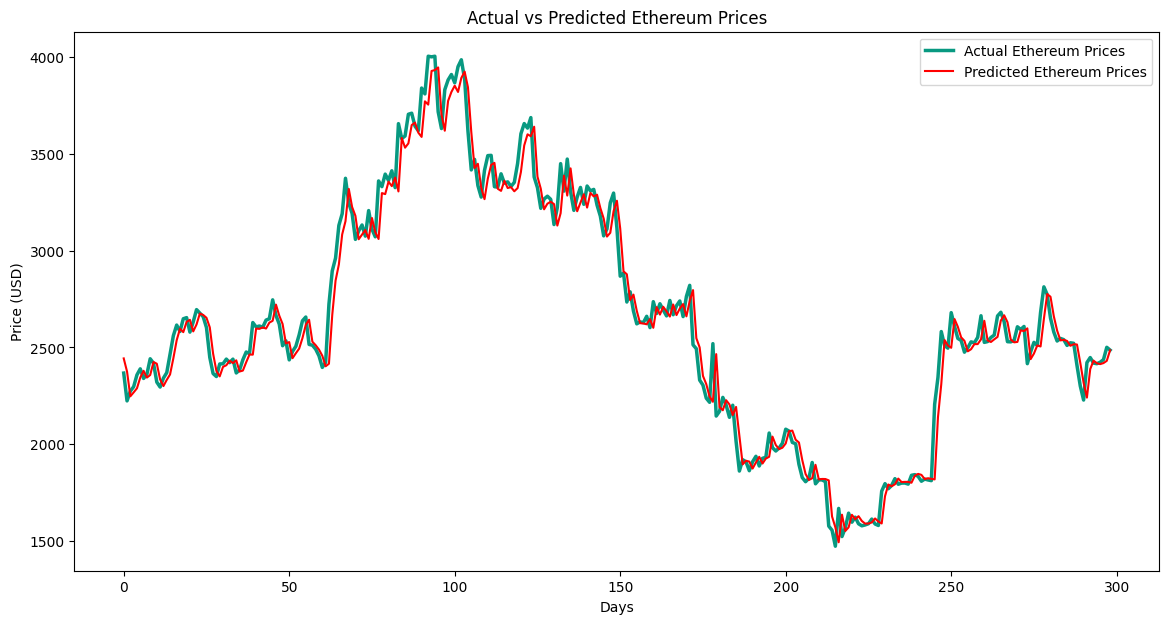

In [111]:
plt.figure(figsize=(14, 7))

plt.plot(y_test_scaled, label='Actual Ethereum Prices', color='#089981', linewidth=2.5)
plt.plot(predictions, label='Predicted Ethereum Prices', color='red', linewidth=1.5)

plt.title('Actual vs Predicted Ethereum Prices')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()

# Simpan gambar ke file PNG dengan resolusi 300 dpi
plt.savefig("actual_vs_predicted_eth.png", dpi=300, bbox_inches='tight')  # nama file bisa diganti sesuai kebutuhan

plt.show()


In [112]:
future_days = 1

last_30_days = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_30_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model_gru.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0, 0])

    new_scaled_data = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)

future_dates = pd.date_range(start=data.index[-1], periods=future_days+1, freq='D')[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Visualisasi Hasil Prediksi

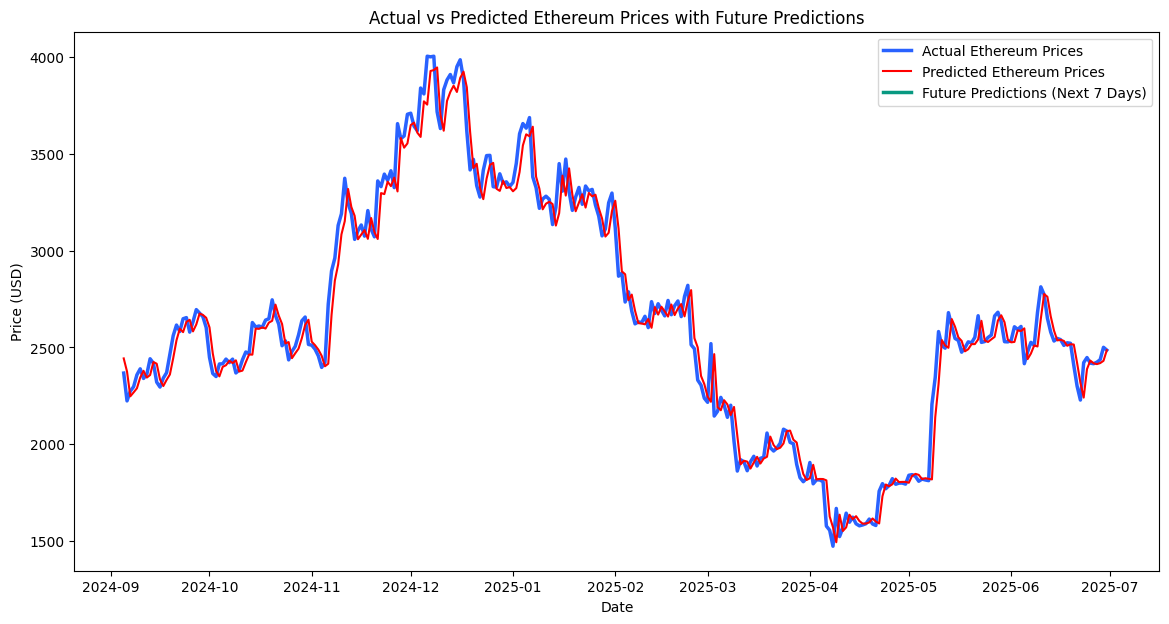

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(data.index[-len(y_test_scaled):], y_test_scaled, label='Actual Ethereum Prices', color='#2962ff', linewidth=2.5)
plt.plot(data.index[-len(y_test_scaled):], predictions, label='Predicted Ethereum Prices', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next Days)', color='#089981', linewidth=2.5)

plt.title('Actual vs Predicted Ethereum Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

plt.show()

In [114]:
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions
})

future_predictions_df

,Date,Predicted Price
0,2025-07-01,2481.568604


In [115]:
import os

# Simpan model
if not os.path.exists('models'):
    os.makedirs('models')
model_gru.save('models/MODEL_GRU.h5')
print("\nModel GRU berhasil dilatih dan disimpan di 'models'")


Model GRU berhasil dilatih dan disimpan di 'models'
